Top Apps finalised which also have reviews:  
- AMAZON SHOPPING  
- GMAIL  
- COOKING FEVER  
- Horoscopes – Daily Zodiac Horoscope and Astrology  
- Diary with lock  
- APUS Launcher - Theme, Wallpaper, Hide Apps  
- CM Launcher 3D - Theme, Wallpapers, Efficient  
- Cache Cleaner-DU Speed Booster (booster & cleaner)  
- Clash Royale  
- Candy Crush Saga  
- Hay Day  

In [1]:
import re,os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
reviews_data = pd.read_csv('googleplaystore_user_reviews.csv')
apps_to_look_for = ['Amazon Shopping','Gmail','Cooking Fever','Horoscopes – Daily Zodiac Horoscope and Astrology',
                   'Diary with lock','APUS Launcher - Theme, Wallpaper, Hide Apps','CM Launcher 3D - Theme, Wallpapers, Efficient',
                    'Cache Cleaner-DU Speed Booster (booster & cleaner)','Clash Royale','Candy Crush Saga','Hay Day']
reviews_data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [3]:
# Creating a Function to Fetch reviews and append in one dataframe!
def fetch_reviews_df_apps(df,list_of_apps):
    final_df = pd.DataFrame(columns= df.columns)
    for i in list_of_apps:
        if i in df.App.get_values():
            sub_df = df[df.App == i].reset_index(drop=True)
        else:
            pass
        # Merging/Concatenating DF's
        final_df = pd.concat([final_df,sub_df])
    # Dropping the NA values rows
    final_df.dropna(axis='rows',inplace=True)
    return final_df.reset_index(drop=True)

In [4]:
prepared_reviews_df = fetch_reviews_df_apps(reviews_data,apps_to_look_for)
prepared_reviews_df.App.value_counts()

Candy Crush Saga                                      240
Clash Royale                                          165
Cooking Fever                                         135
Diary with lock                                        99
Gmail                                                  64
Hay Day                                                61
Amazon Shopping                                        45
Horoscopes – Daily Zodiac Horoscope and Astrology      35
APUS Launcher - Theme, Wallpaper, Hide Apps            31
Cache Cleaner-DU Speed Booster (booster & cleaner)     26
CM Launcher 3D - Theme, Wallpapers, Efficient          18
Name: App, dtype: int64

In [5]:
prepared_reviews_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,Amazon Shopping,Terrible change way switch wishlists. When scr...,Negative,-0.166667,0.700000
1,Amazon Shopping,"Completely useless. They changed triple price,...",Negative,-0.300000,0.600000
2,Amazon Shopping,"Hey, Jeff Bezos, employees living cars feeling...",Positive,0.100000,0.657778
3,Amazon Shopping,"Good app, keeps supposed to. Error messages do...",Positive,0.875000,0.600000
4,Amazon Shopping,This actually looking dogs error messages unde...,Neutral,0.000000,0.100000


In [6]:
# Let's finalise 0,1,2 for Negative/Positive/Neutral Sentiments

prepared_reviews_df['Sentiment'] = prepared_reviews_df['Sentiment'].apply(lambda x: 0 if x == 'Negative' else(1 if x == 'Positive' else 2))
prepared_reviews_df.head(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,Amazon Shopping,Terrible change way switch wishlists. When scr...,0,-0.166667,0.700000
1,Amazon Shopping,"Completely useless. They changed triple price,...",0,-0.300000,0.600000
2,Amazon Shopping,"Hey, Jeff Bezos, employees living cars feeling...",1,0.100000,0.657778
3,Amazon Shopping,"Good app, keeps supposed to. Error messages do...",1,0.875000,0.600000
4,Amazon Shopping,This actually looking dogs error messages unde...,2,0.000000,0.100000
5,Amazon Shopping,Amazon stretched thin? The slow hell. Click it...,0,-0.100000,0.475000
6,Amazon Shopping,"Once unnecessary permissions disabled, mostly ...",0,-0.180000,0.600000
7,Amazon Shopping,"Always slow painful use, I feel back days dial...",2,0.000000,0.512500
8,Amazon Shopping,Why Apple's supports long press shortcuts not?...,1,0.008333,0.533333
9,Amazon Shopping,The home page sloppy otherwise connects many A...,0,-0.013889,0.666667


In [7]:
sentiment_data = prepared_reviews_df.loc[:,['Translated_Review','Sentiment']]
print('Shape: ',sentiment_data.shape)
print('----------------------------------------------------')
sentiment_data.head(8)

Shape:  (919, 2)
----------------------------------------------------


,Translated_Review,Sentiment
0,Terrible change way switch wishlists. When scr...,0
1,"Completely useless. They changed triple price,...",0
2,"Hey, Jeff Bezos, employees living cars feeling...",1
3,"Good app, keeps supposed to. Error messages do...",1
4,This actually looking dogs error messages unde...,2
5,Amazon stretched thin? The slow hell. Click it...,0
6,"Once unnecessary permissions disabled, mostly ...",0
7,"Always slow painful use, I feel back days dial...",2


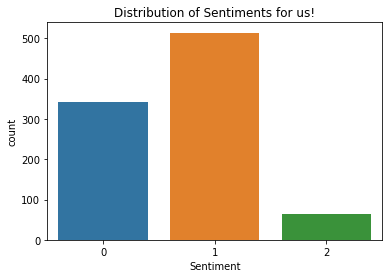

In [8]:
sns.countplot(x = 'Sentiment',data = sentiment_data);
plt.title('Distribution of Sentiments for us!');

### Now from here, we will do the following actions on the Translated_Review column:  
- Remove Punctuations  
- Remove unwanted STOPWORDS  
- Remove **expressions/symbols like commas,questions marks, apostrophies, dash, etc.**  
- Lemmatization  
- Prepare the Tokenization/Word Embedding for the Review.  

In [9]:
to_be_replaced_with_no_space = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
to_be_replaced_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def process_review(reviews):
    reviews = [to_be_replaced_with_no_space.sub('',line.lower()) for line in reviews]
    reviews = [to_be_replaced_with_space.sub(' ',line.lower()) for line in reviews]
    
    return reviews

train = sentiment_data.Translated_Review[:643]
test = sentiment_data.Translated_Review[643:]

In [10]:
def perform_modelling(df_train,df_test):
    cv = CountVectorizer(binary=True)
    cv.fit(df_train)
    X = cv.transform(df_train)
    X_test = cv.transform(df_test)
    target = sentiment_data.Sentiment[:643]
    X_train, X_val, y_train, y_val = train_test_split(
        X, target, train_size = 0.7
    )

    for c in [0.01,0.05,0.1,0.25,0.5,0.75]:
        clf = svm.SVC(decision_function_shape='ovo',C=c)
        clf.fit(X_train,y_train)
        print('Accuracy for C=%s :%s'%(c,round(accuracy_score(y_val,clf.predict(X_val)),4)))

In [11]:
# Now let's process our Reviews
cleaned_train = process_review(train)
cleaned_test = process_review(test)
print(cleaned_train[2])
print('---------------------------')
print(sentiment_data.Translated_Review[2])

hey jeff bezos employees living cars feeling suicidal poor work conditions written meet unrealistic productivity demands even much speak employees all while living mansion plan build rocketships billions make profits instead making sure employees well taken care of how feel that do feel good yourself
---------------------------
Hey, Jeff Bezos, employees living cars feeling suicidal poor work conditions written meet unrealistic productivity demands even much speak employees. All while, living mansion plan build rocketships billions make profits instead making sure employees well taken care of. How feel that? Do feel good yourself?


In [12]:
print(cleaned_train[5])
print('---------------------------')
print(sentiment_data.Translated_Review[5])

amazon stretched thin the slow hell click item device takes sweet time load not internet mb s
---------------------------
Amazon stretched thin? The slow hell. Click item device takes sweet time load. Not internet (300mb/s)


In [13]:
perform_modelling(cleaned_train,cleaned_test)

Accuracy for C=0.01 :0.6321
Accuracy for C=0.05 :0.6321
Accuracy for C=0.1 :0.6321
Accuracy for C=0.25 :0.6321
Accuracy for C=0.5 :0.6943
Accuracy for C=0.75 :0.7617


In [14]:
the_library_of_stop_words = stopwords.words('english')
def remove_stop_words(text_input):
    removed_stop_words = []
    for review in text_input:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in the_library_of_stop_words])
        )
    return removed_stop_words

In [15]:
cleaned_train_data_from_stop_words = remove_stop_words(cleaned_train)
cleaned_test_data_from_stop_words = remove_stop_words(cleaned_test)

In [16]:
print(cleaned_train_data_from_stop_words[5])
print('---------------------------')
print(sentiment_data.Translated_Review[5])

amazon stretched thin slow hell click item device takes sweet time load internet mb
---------------------------
Amazon stretched thin? The slow hell. Click item device takes sweet time load. Not internet (300mb/s)


In [17]:
perform_modelling(cleaned_train_data_from_stop_words,cleaned_test_data_from_stop_words)

Accuracy for C=0.01 :0.658
Accuracy for C=0.05 :0.658
Accuracy for C=0.1 :0.658
Accuracy for C=0.25 :0.658
Accuracy for C=0.5 :0.7306
Accuracy for C=0.75 :0.7772


In [18]:
cv = CountVectorizer(binary=True)
cv.fit(cleaned_train_data_from_stop_words)
X = cv.transform(cleaned_train_data_from_stop_words)
X_test = cv.transform(cleaned_test_data_from_stop_words)
target = sentiment_data.Sentiment[:643]
target_test = sentiment_data.Sentiment[643:]
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.7
)

# Now let's check for the test set
lr_model_stemmed = svm.SVC(decision_function_shape='ovo',C=0.75)
lr_model_stemmed.fit(X,target)
print('Final Accuracy: ',round(accuracy_score(target_test,lr_model_stemmed.predict(X_test)),4))

Final Accuracy:  0.7246


In [19]:
def lemmatizing_of_data(text_input):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in text.split()]) for text in text_input]

In [20]:
# For Stop Words
lemmatized_reviews_train_stop_words_excluded = lemmatizing_of_data(cleaned_train_data_from_stop_words)
lemmatized_reviews_test_stop_words_excluded = lemmatizing_of_data(cleaned_test_data_from_stop_words)

In [21]:
perform_modelling(lemmatized_reviews_train_stop_words_excluded,lemmatized_reviews_test_stop_words_excluded)

Accuracy for C=0.01 :0.6425
Accuracy for C=0.05 :0.6425
Accuracy for C=0.1 :0.6425
Accuracy for C=0.25 :0.6425
Accuracy for C=0.5 :0.7098
Accuracy for C=0.75 :0.7617


In [22]:
# For only Cleaned Data
lemmatized_reviews_train = lemmatizing_of_data(cleaned_train)
lemmatized_reviews_test = lemmatizing_of_data(cleaned_test)
perform_modelling(lemmatized_reviews_train,lemmatized_reviews_test)

Accuracy for C=0.01 :0.6062
Accuracy for C=0.05 :0.6062
Accuracy for C=0.1 :0.6062
Accuracy for C=0.25 :0.6062
Accuracy for C=0.5 :0.6632
Accuracy for C=0.75 :0.7202


##### Checking TEST Performance

In [23]:
cv = CountVectorizer(binary=True)
cv.fit(lemmatized_reviews_train)
X = cv.transform(lemmatized_reviews_train)
X_test = cv.transform(lemmatized_reviews_test)
target = sentiment_data.Sentiment[:643]
target_test = sentiment_data.Sentiment[643:]
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.7
)

# Now let's check for the test set
lr_model_stemmed = svm.SVC(decision_function_shape='ovo',C=0.75)
lr_model_stemmed.fit(X,target)
print('Final Accuracy: ',round(accuracy_score(target_test,lr_model_stemmed.predict(X_test)),4))

Final Accuracy:  0.75


In [24]:
def perform_modelling_n_gram(df_train,df_test):
    ngram_cv = CountVectorizer(binary=True,ngram_range=(1,2))
    ngram_cv.fit(df_train)
    X = ngram_cv.transform(df_train)
    X_test = ngram_cv.transform(df_test)
    target = sentiment_data.Sentiment[:643]
    X_train, X_val, y_train, y_val = train_test_split(
        X, target, train_size = 0.7
    )

    for c in [0.01,0.05,0.1,0.25,0.5,0.75]:
        clf = svm.SVC(decision_function_shape='ovo',C=c)
        clf.fit(X_train,y_train)
        print('Accuracy for C=%s :%s'%(c,round(accuracy_score(y_val,clf.predict(X_val)),4)))

In [25]:
perform_modelling_n_gram(cleaned_train_data_from_stop_words,cleaned_test_data_from_stop_words)

Accuracy for C=0.01 :0.5751
Accuracy for C=0.05 :0.5751
Accuracy for C=0.1 :0.5751
Accuracy for C=0.25 :0.5751
Accuracy for C=0.5 :0.601
Accuracy for C=0.75 :0.6891


In [26]:
perform_modelling_n_gram(lemmatized_reviews_train,lemmatized_reviews_test)

Accuracy for C=0.01 :0.5699
Accuracy for C=0.05 :0.5699
Accuracy for C=0.1 :0.5699
Accuracy for C=0.25 :0.5699
Accuracy for C=0.5 :0.5751
Accuracy for C=0.75 :0.6943


Points to note:  
- C values for which we get much better accuracy is **0.5 and 0.75**.  
- Now, the better accuracy we get is around **0.75** for the model built on **Clean Data Set** without bringing N GRAM or Lemmatization in picture   
- Now, we know that we SVM model tried to learn the pattern, but couldn't. Next we will try the below things:  
    - Find the Top Positive and Top Negative Words.  
    - Use some Deep Learning techniques like RNN maybe/BERT for better Sentiment Analysis results.  
    
###### Some of the Challenges we have:  
1. The Sentiment is Multi Class in this problem statement.  
2. We have less amout of Data for reviews scenarios.  
3. We also see, that there is high imbalance between 0,1,2 reviews. So for Balancing, we can either remove **Neutral** reviews or merge them with **Negative** reviews.  